In [1]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Define dataset paths
DATASET_PATH = "/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset"

# Classes in the dataset
CLASSES = ["Bengin cases", "Malignant cases", "Normal cases"]
CLASS_LABELS = {cls: i for i, cls in enumerate(CLASSES)}  # Convert classes to numerical labels

# Image size required for the model
IMG_SIZE = (256, 256)

# Function to load and preprocess images
def load_images(dataset_path, img_size):
    images, labels = [], []
    for category in CLASSES:
        category_path = os.path.join(dataset_path, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_resized = cv2.resize(img, img_size) / 255.0  # Resize and normalize images
                images.append(img_resized)
                labels.append(CLASS_LABELS[category])

    return np.array(images), np.array(labels)

# Load the dataset
X, y = load_images(DATASET_PATH, IMG_SIZE)

# Convert images to 3 channels (models expect colored images)
X = np.expand_dims(X, axis=-1)  # Add grayscale channel
X = np.repeat(X, 3, axis=-1)  # Repeat channels to make them 3 channels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
X_train_resampled = X_train_resampled.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 3)  # Reshape the data

# Convert labels to One-Hot Encoding
y_train_resampled = to_categorical(y_train_resampled, num_classes=len(CLASSES))
y_test = to_categorical(y_test, num_classes=len(CLASSES))

print(f"Number of images after SMOTE: {X_train_resampled.shape[0]}")

Number of images after SMOTE: 1344


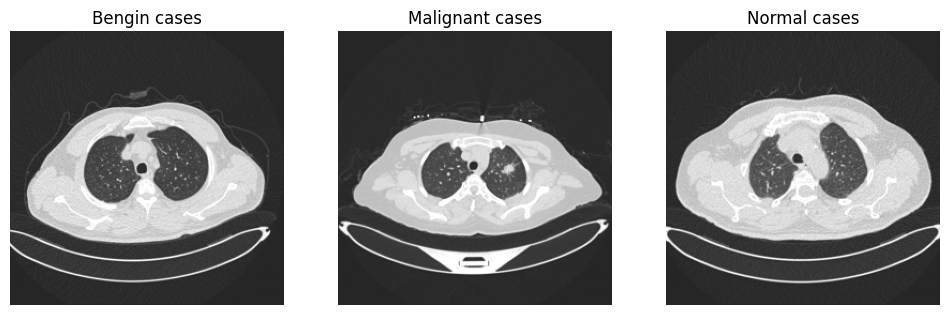

In [6]:
import matplotlib.pyplot as plt
import random

# Function to display random images from each class
def plot_random_images(X, y, classes, num_images=3):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

    for i, class_label in enumerate(classes):
        class_indices = np.where(y == i)[0]
        random_index = random.choice(class_indices)
        img = X[random_index]

        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(class_label)
        axes[i].axis("off")

    plt.show()

# Display random images from each class
plot_random_images(X, y, CLASSES)


In [7]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Multiply, Reshape, Conv2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Step 2: Build the Model
# Load DenseNet169 with local weights
densenet169_weights_path = "/kaggle/input/densenet169-weight/densenet169_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_model = DenseNet169(include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), weights=None)
base_model.load_weights(densenet169_weights_path)

# Step 3: Add Attention Mechanisms (Squeeze-and-Excitation Block)
def se_block(input_tensor, ratio=16):
    channels = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(channels // ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    se = Reshape((1, 1, channels))(se)
    return Multiply()([input_tensor, se])

x = base_model.output
x = se_block(x)  # Add SE block

# Step 4: Add Multi-Scale Feature Fusion (Feature Pyramid Network)
def fpn_block(pyramid_features):
    fused_features = []
    for i in range(len(pyramid_features) - 1):
        upsampled = UpSampling2D()(pyramid_features[i + 1])
        fused = Concatenate()([pyramid_features[i], upsampled])
        fused = Conv2D(256, (3, 3), padding='same')(fused)
        fused_features.append(fused)
    return fused_features

# Extract pyramid features from DenseNet169
dense_block_outputs = [
    base_model.get_layer('conv2_block6_concat').output,  # Output of Dense Block 1
    base_model.get_layer('conv3_block12_concat').output,  # Output of Dense Block 2
    base_model.get_layer('conv4_block24_concat').output,  # Output of Dense Block 3
    base_model.get_layer('conv5_block16_concat').output   # Output of Dense Block 4
]

fused_features = fpn_block(dense_block_outputs)
x = GlobalAveragePooling2D()(fused_features[-1])
x = Dense(len(CLASSES), activation='softmax')(x)  # Output layer for 3 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Step 5: Add Custom Loss Function for Imbalanced Data
def focal_loss(gamma=2., alpha=[10, 1, 2]):  # Adjust alpha for class weights
    def focal_loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        y_true = tf.cast(y_true, tf.float32)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -tf.reduce_sum(alpha * tf.pow(1. - pt, gamma) * tf.math.log(pt), axis=-1)
    return focal_loss_fn

# Step 6: Compile the Model
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

# Step 7: Add Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Step 8: Train the Model
history = model.fit(
    X_train_resampled, y_train_resampled,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=20,
    callbacks=[reduce_lr]
)


Epoch 1/20


I0000 00:00:1742614910.109481     109 service.cc:145] XLA service 0x7f7a94008cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742614910.109566     109 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1742614997.418770     109 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_16', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_68', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_70', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1190', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1176', 8 byt

42/42 ━━━━━━━━━━━━━━━━━━━━ 173s 732ms/step - accuracy: 0.4361 - loss: 20.2977 - val_accuracy: 0.3773 - val_loss: 45.7177 - learning_rate: 0.0010
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - accuracy: 0.5897 - loss: 3.1315 - val_accuracy: 0.4773 - val_loss: 25.3867 - learning_rate: 0.0010
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - accuracy: 0.7940 - loss: 1.2242 - val_accuracy: 0.5136 - val_loss: 35.3760 - learning_rate: 0.0010
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - accuracy: 0.8905 - loss: 0.7672 - val_accuracy: 0.5136 - val_loss: 30.0021 - learning_rate: 0.0010
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - accuracy: 0.8978 - loss: 0.5721 - val_accuracy: 0.5000 - val_loss: 8.4431 - learning_rate: 0.0010
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.8378 - loss: 1.0219 - val_accuracy: 0.5818 - val_loss: 14.6629 - learning_rate: 0.0010
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.9015 - loss: 0.4607

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


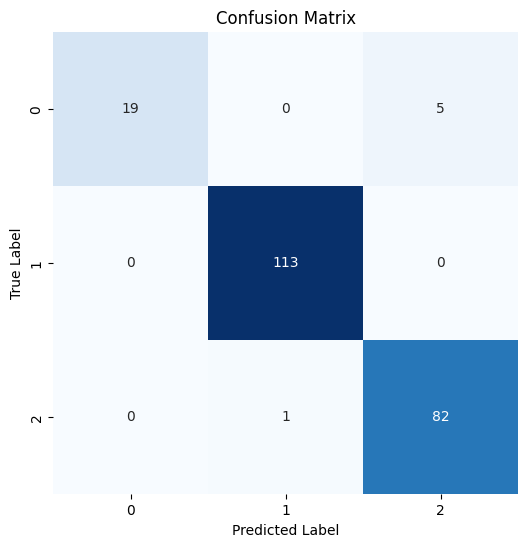

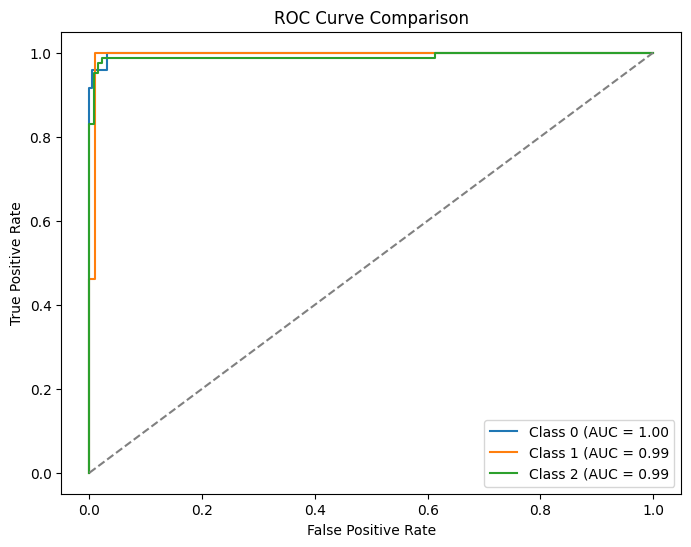

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.keras.utils import to_categorical

# Assuming you have y_test (ground truth) and y_pred (model predictions as probabilities)
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.gca().set_facecolor('white')  # Set white background
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
for i in range(len(CLASSES)):
    fpr, tpr, _ = roc_curve(to_categorical(y_true, num_classes=len(CLASSES))[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f}")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.gca().set_facecolor('white')  # Set white background
plt.show()

In [10]:

# Step 9: Evaluate the Model
from sklearn.metrics import classification_report

# Get predictions
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_test_labels, y_pred, target_names=CLASSES)
print("Classification Report:\n", report)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Classification Report:
                  precision    recall  f1-score   support

   Bengin cases       1.00      0.79      0.88        24
Malignant cases       0.99      1.00      1.00       113
   Normal cases       0.94      0.99      0.96        83

       accuracy                           0.97       220
      macro avg       0.98      0.93      0.95       220
   weighted avg       0.97      0.97      0.97       220

